# Solución sencilla — Tweets con Spark SQL

Este notebook:
1. Carga `tweets.csv` en un DataFrame de Spark.
2. Agrega `num_palabras` (conteo simple de palabras).
3. Crea la vista temporal `tweets`.
4. Ejecuta consultas SQL: total de tweets, promedio de palabras, top 5 usuarios.
5. Dibuja un gráfico de barras con el top 5 de usuarios más activos.

## 1) Crear SparkSession

In [1]:
import os, sys
from pyspark.sql import SparkSession

# Recomendado (Windows/Colab): usar el mismo Python para driver y workers
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (SparkSession.builder
         .appName("Tweets_Ejercicio_Solucion")
         .config("spark.python.use.daemon","false")
         .config("spark.python.worker.reuse","false")
         .getOrCreate())

spark

## 2) Cargar `tweets.csv`

In [2]:
csv_path = "tweets.csv"

df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(csv_path))

df.show(5, truncate=False)
df.printSchema()

+--------+---------+-------------------+--------------------------------------------------+--------------------------+
|post_id |user     |ts                 |text                                              |hashtags                  |
+--------+---------+-------------------+--------------------------------------------------+--------------------------+
|p0_00000|user_0138|2025-08-25 08:57:11|Tips de optimización en PySpark y particionado    |#kafka #spark             |
|p0_00001|user_0195|2025-08-25 08:41:40|Delta y formatos columnares mejoran el rendimiento|#nlp                      |
|p0_00002|user_0070|2025-08-25 10:54:23|Arquitecturas de datos modernas en la nube        |#cloud #bigdata           |
|p0_00003|user_0194|2025-08-25 09:35:41|Tips de optimización en PySpark y particionado    |#opensource #spark        |
|p0_00004|user_0073|2025-08-25 09:41:19|¿Cuál es tu librería favorita para ETL?           |#datascience #deeplearning|
+--------+---------+-------------------+--------

## 3) Preparar datos y vista temporal

In [3]:
from pyspark.sql.functions import size, split, col

# Conteo simple de palabras separadas por espacio
df = df.withColumn("num_palabras", size(split(col("text"), " ")))

# Crear vista temporal
df.createOrReplaceTempView("tweets")

## 4) Consultas Spark SQL

In [4]:
# 4a) Total de tweets
spark.sql("SELECT COUNT(*) AS total_tweets FROM tweets").show()

+------------+
|total_tweets|
+------------+
|       16000|
+------------+



In [5]:
# 4b) Promedio de palabras por tweet
spark.sql("SELECT AVG(num_palabras) AS promedio_palabras FROM tweets").show()

+-----------------+
|promedio_palabras|
+-----------------+
|          6.46625|
+-----------------+



In [6]:
# 4c) Top 5 usuarios más activos
top_users = spark.sql('''
SELECT user, COUNT(*) AS total
FROM tweets
GROUP BY user
ORDER BY total DESC
LIMIT 5
''')
top_users.show(truncate=False)

+---------+-----+
|user     |total|
+---------+-----+
|user_0159|74   |
|user_0165|73   |
|user_0288|71   |
|user_0192|70   |
|user_0199|70   |
+---------+-----+



## 5) Gráfico — Top 5 usuarios por número de tweets

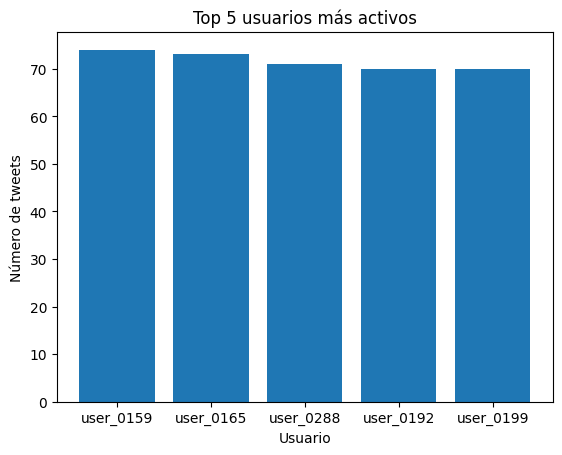

In [7]:
import matplotlib.pyplot as plt

pdf = top_users.toPandas()

plt.figure()
plt.bar(pdf["user"], pdf["total"])
plt.title("Top 5 usuarios más activos")
plt.xlabel("Usuario")
plt.ylabel("Número de tweets")
plt.show()